In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import numpy as np
#assert torch.cuda.is_available()

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current Device being used:",device)

Current Device being used: cuda:0


In [26]:
transform = transforms.Compose([transforms.ToTensor()])
digits_X, digits_y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(digits_X, digits_y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [49]:
train_data = [(torch.tensor(X_train[i],dtype=torch.float32),y_train[i]) for i in range(len(y_train))]
test_data = [(torch.tensor(X_test[i],dtype=torch.float32),y_test[i]) for i in range(len(y_test))]

In [50]:
actual_train_data = [train_data[i] for i in range(1000)] #Split into Test/train
val_data = [train_data[i] for i in range(1000,1437)]

In [51]:
train_loader = DataLoader(actual_train_data,batch_size=32,shuffle=True)
val_loader = DataLoader(val_data,batch_size=32,shuffle=False)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [56]:
class TwoLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(64,30)
        self.l2 = nn.Linear(30,10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        x = self.flatten(x)
        out1 = self.relu(self.l1(x))
        out2 = self.softmax(self.l2(out1))
        return out2

In [91]:
model = TwoLayerNN().to(device)

In [92]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) #I got this off of stack exchange
print("The total amount of parameters in the model that can be trained is:",total_params)

The total amount of parameters in the model that can be trained is: 2260


In [95]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(),lr=1e-2)

num_epochs = 100
loss_mean = []
accuracy = []

loop = tqdm(total=len(train_loader)*num_epochs,position=0)

for epoch in range(num_epochs):
    model.train()
    loss_list = []
    for images,targets in train_loader: #This is the train loop
        images,targets = images.to(device),targets.to(device)
        optimizer.zero_grad()
        yhats = model(images)
        loss = loss_func(yhats,targets)
        loss_list.append(loss.item())
        loss.backward() 
        optimizer.step()
        loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss.item()))
        loop.update()
    loss_mean.append(np.mean(loss_list))

    #Validate
    model.eval()
    accs = []
    for images,targets in val_loader:
        images,targets = images.to(device),targets.to(device)
        yhats = model(images)
        accs.append((torch.sum(torch.argmax(yhats,dim=1)==targets)/len(targets)).item())
    accuracy.append(np.mean(accs))
loop.close()

accuracies = []
model.eval()
for images,targets in test_loader:
    images,targets = images.to(device),targets.to(device)
    yhats = model(images)
    accuracies.append((torch.sum(torch.argmax(yhats,dim=1)==targets)/len(targets)).item())
print("Test Set Accuracy:",torch.mean(torch.tensor(accuracies)).item())

epoch:99, loss:1.4619: 100%|██████████| 3200/3200 [00:14<00:00, 223.52it/s]


Test Set Accuracy: 0.9694444537162781


Text(0, 0.5, 'Accuracy')

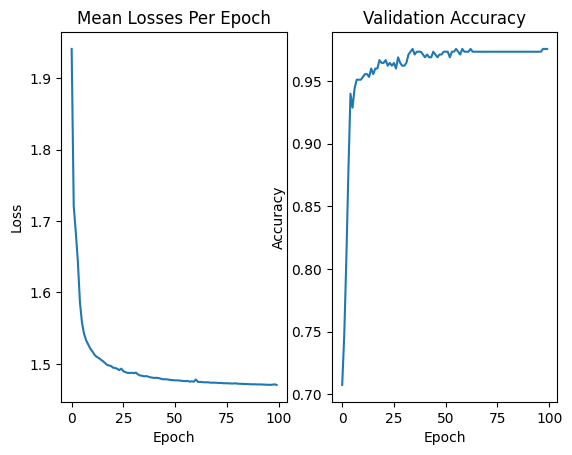

In [96]:
fig,ax = plt.subplots(1,2)
ax[0].plot(loss_mean)
ax[0].set_title("Mean Losses Per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(accuracy)
ax[1].set_title("Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

In [100]:
print(model.l1.weight)

print(model.l2.weight)

Parameter containing:
tensor([[-0.0877, -0.1384, -0.0033,  ...,  0.1513,  0.1288,  0.0591],
        [-0.0065,  0.1813,  0.1544,  ...,  0.0499,  0.0177,  0.2654],
        [-0.0431, -0.2317, -0.1261,  ...,  0.0611,  0.0333,  0.0476],
        ...,
        [-0.0682,  0.0932, -0.0060,  ...,  0.0259, -0.1104,  0.0205],
        [ 0.0582,  0.1229,  0.1150,  ..., -0.1353, -0.0670, -0.0525],
        [ 0.0078, -0.0215,  0.0313,  ...,  0.0861,  0.0338, -0.1205]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0036, -0.1117, -0.1650, -0.3003,  0.1368,  0.2147, -0.2471,  0.1627,
         -0.4154, -0.3811,  0.1319, -0.0930,  0.0144,  0.0346, -0.1022, -0.1594,
          0.0405, -0.1751, -0.1164,  0.0192,  0.1586,  0.0882,  0.2422,  0.2599,
          0.1811, -0.2913, -0.1285,  0.0843, -0.2067,  0.1059],
        [ 0.0642,  0.2511,  0.1930, -0.0590,  0.1848,  0.0745, -0.3333, -0.2012,
         -0.1127, -0.1284,  0.0732, -0.1668,  0.1749, -0.2114, -0.1233, -0.0802,
         